> reconstruction error train=0.000, test=0.000
> classifier accuracy layers=2, train=0.838, test=0.832
> reconstruction error train=0.000, test=0.000
> classifier accuracy layers=3, train=0.818, test=0.844
> reconstruction error train=0.001, test=0.002
> classifier accuracy layers=4, train=0.836, test=0.836
> reconstruction error train=0.004, test=0.004
> classifier accuracy layers=5, train=0.822, test=0.840
> reconstruction error train=2.327, test=2.695
> classifier accuracy layers=6, train=0.748, test=0.748
> reconstruction error train=10.410, test=10.688
> classifier accuracy layers=7, train=0.342, test=0.326


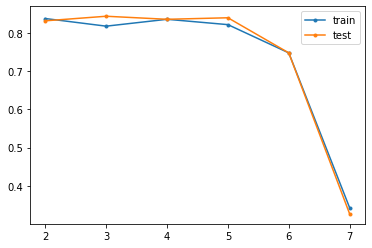

In [3]:
# unsupervised greedy layer-wise pretraining for blobs classification problem
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

# prepare the dataset
def prepare_data():
	# generate 2d classification dataset
	X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
	# one hot encode output variable
	y = to_categorical(y)
	# split into train and test
	n_train = 500
	trainX, testX = X[:n_train, :], X[n_train:, :]
	trainy, testy = y[:n_train], y[n_train:]
	return trainX, testX, trainy, testy

# define, fit and evaluate the base autoencoder
def base_autoencoder(trainX, testX):
	# define model
	model = Sequential()
	model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(2, activation='linear'))
	# compile model
	model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
	# fit model
	model.fit(trainX, trainX, epochs=100, verbose=0)
	# evaluate reconstruction loss
	train_mse = model.evaluate(trainX, trainX, verbose=0)
	test_mse = model.evaluate(testX, testX, verbose=0)
	print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))
	return model

# evaluate the autoencoder as a classifier
def evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy):
	# remember the current output layer
	output_layer = model.layers[-1]
	# remove the output layer
	model.pop()
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False
	# add new output layer
	model.add(Dense(3, activation='softmax'))
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)
	# evaluate model
	_, train_acc = model.evaluate(trainX, trainy, verbose=0)
	_, test_acc = model.evaluate(testX, testy, verbose=0)
	# put the model back together
	model.pop()
	model.add(output_layer)
	model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
	return train_acc, test_acc

# add one new layer and re-train only the new layer
def add_layer_to_autoencoder(model, trainX, testX):
	# remember the current output layer
	output_layer = model.layers[-1]
	# remove the output layer
	model.pop()
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False
	# add a new hidden layer
	model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
	# re-add the output layer
	model.add(output_layer)
	# fit model
	model.fit(trainX, trainX, epochs=100, verbose=0)
	# evaluate reconstruction loss
	train_mse = model.evaluate(trainX, trainX, verbose=0)
	test_mse = model.evaluate(testX, testX, verbose=0)
	print('> reconstruction error train=%.3f, test=%.3f' % (train_mse, test_mse))

# prepare data
trainX, testX, trainy, testy = prepare_data()
# get the base autoencoder
model = base_autoencoder(trainX, testX)
# evaluate the base model
scores = dict()
train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy)
print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
scores[len(model.layers)] = (train_acc, test_acc)
# add layers and evaluate the updated model
n_layers = 5
for _ in range(n_layers):
	# add layer
	add_layer_to_autoencoder(model, trainX, testX)
	# evaluate model
	train_acc, test_acc = evaluate_autoencoder_as_classifier(model, trainX, trainy, testX, testy)
	print('> classifier accuracy layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
	# store scores for plotting
	scores[len(model.layers)] = (train_acc, test_acc)
# plot number of added layers vs accuracy
keys = list(scores.keys())
pyplot.plot(keys, [scores[k][0] for k in keys], label='train', marker='.')
pyplot.plot(keys, [scores[k][1] for k in keys], label='test', marker='.')
pyplot.legend()
pyplot.show()

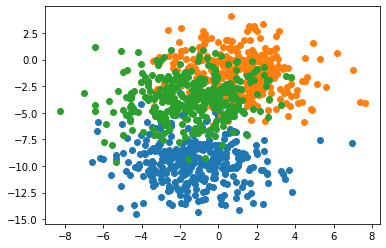

In [4]:

# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
# scatter plot for each class value
for class_value in range(3):
	# select indices of points with the class label
	row_ix = where(y == class_value)
	# scatter plot for points with a different color
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show plot
pyplot.show()